<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/GreekBERTreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [2]:
from transformers import BertModel, BertTokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [3]:
import torch
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length = 32):
        self.max_length = max_length
        self.labels = df[["lat", "lon"]].values
        self.texts = df.text.apply(lambda txt: tokenizer(txt, padding='max_length', max_length = self.max_length, truncation=True, return_tensors="pt")).values

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [4]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.norm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = pooled_output
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        #x = self.norm(x)
        x = self.linear2(x)
        return x

In [9]:
from torch.optim import Adam
from tqdm import tqdm

from transformers import AutoTokenizer, BertModel

def finetune(model, train_data, val_data, 
             learning_rate=2e-5, epochs=100, criterion=nn.MSELoss(),
             batch_size=32, max_length=16):
    
    train_loss = []
    val_loss = []
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, drop_last=False)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.train()
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)                
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_loss.append(total_loss_train)
            
            total_loss_val = 0
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    batch_loss = criterion(output, val_label.float())
                    total_loss_val += batch_loss.item()
            val_loss.append(total_loss_val)
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f}')
    
    return (train_loss, val_loss)

In [12]:
criterion = nn.MSELoss()
model = BertClassifier(num_classes=2)
max_length = 16

history = finetune(model, 
                   Dataset(train, max_length=max_length), 
                   Dataset(dev, max_length=max_length), 
                   epochs=10,
                   max_length=max_length,
                   learning_rate=2e-5, 
                   criterion=criterion)

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 26.17it/s]


Epochs: 1 | Train Loss:  18.722                 | Val Loss:  8.981


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 26.06it/s]


Epochs: 2 | Train Loss:  4.084                 | Val Loss:  1.084


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 26.01it/s]


Epochs: 3 | Train Loss:  0.442                 | Val Loss:  0.186


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.96it/s]


Epochs: 4 | Train Loss:  0.178                 | Val Loss:  0.172


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.94it/s]


Epochs: 5 | Train Loss:  0.174                 | Val Loss:  0.169


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.91it/s]


Epochs: 6 | Train Loss:  0.175                 | Val Loss:  0.169


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.88it/s]


Epochs: 7 | Train Loss:  0.174                 | Val Loss:  0.170


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.82it/s]


Epochs: 8 | Train Loss:  0.175                 | Val Loss:  0.169


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.82it/s]


Epochs: 9 | Train Loss:  0.175                 | Val Loss:  0.171


100%|█████████████████████████████████████████████████████████████| 324/324 [00:12<00:00, 25.83it/s]


Epochs: 10 | Train Loss:  0.175                 | Val Loss:  0.170


In [13]:
history

([193767.97003173828,
  42273.33701133728,
  4575.333186149597,
  1842.7620441913605,
  1803.1491136550903,
  1807.9405426979065,
  1805.4052307605743,
  1812.675077676773,
  1808.5875163078308,
  1809.2865386009216],
 [5163.798980712891,
  623.4195194244385,
  106.97156691551208,
  98.71537613868713,
  96.90811371803284,
  97.0051817893982,
  97.5892927646637,
  97.00850534439087,
  98.29598426818848,
  97.99305009841919])

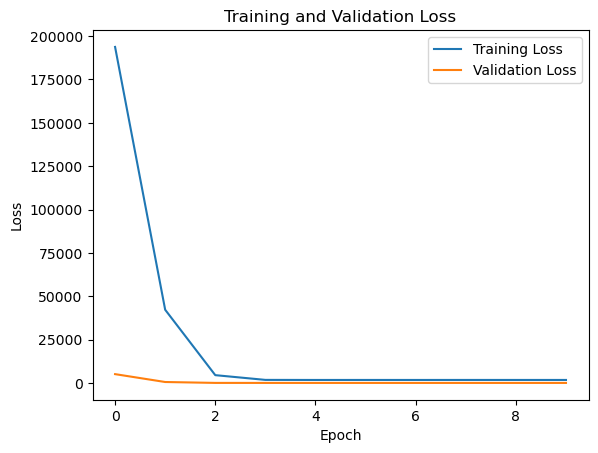

In [14]:
import matplotlib.pyplot as plt

train_loss, val_loss = history

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
def validate(model, dataloader, device="cpu"):
    predictions, gold_labels = [], []
    with torch.no_grad():
        for val_input, val_label in dataloader:
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            predictions.extend(output.cpu().numpy())
            gold_labels.extend(val_label.cpu())
    return predictions, gold_labels

test_dataloader = torch.utils.data.DataLoader(Dataset(test, max_length=max_length), batch_size=32, drop_last=False)
p,l = validate(model.to("cpu"), test_dataloader)
preds_pd = pd.DataFrame({"pred_lat": np.array(p)[:, 0], "pred_lon": np.array(p)[:, 1],
                         "gold_lat": np.array([i.numpy() for i in l])[:, 0], "gold_lon": np.array([i.numpy() for i in l])[:, 1]})
preds_pd.to_csv("proverb.predictions.csv", index=False)

In [18]:
preds_pd

,pred_lat,pred_lon,gold_lat,gold_lon
0,38.172424,24.197517,39.544012,20.308355
1,39.175114,24.844933,41.675933,26.558722
2,38.624561,24.545084,37.420425,24.947956
3,38.538479,24.488670,40.085009,23.977584
4,38.076824,24.245535,35.613661,27.119257
...,...,...,...,...
570,38.397350,24.527529,38.873044,24.524477
571,38.230045,24.356216,38.069275,21.872730
572,37.697838,24.093525,35.308495,24.463342
573,38.053967,24.236284,36.172630,27.919418


In [19]:
from sklearn.metrics import *
print('MAE')
print(f"lat: {mean_absolute_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_absolute_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('MSE')
print(f"lat: {mean_squared_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_squared_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('R2')
print(f"lat: {r2_score(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {r2_score(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")

MAE
lat: 1.44
lon: 2.02
MSE
lat: 3.22
lon: 7.71
R2
lat: -13.87
lon: -82.76


In [17]:
torch.save(model.state_dict(), "checkpoint.pt")